# 全人類がわかるディープラーニング Day5演習

## 概要

本演習では自然言語処理に代表される系列データを扱うためのネットワークであるRNNやその派生ネットワークによる学習を穴埋め形式で実装します。なお、予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。
演習問題文は<font color="Red">赤字</font>です。このファイルは必ず最後までコードをすべて実行し、「最後までコードが実行可能」・「学習結果の出力がある」・「学習が成功している」の３つを満たした状態で提出してください。

所要時間：3~8時間

### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# 乱数シードを指定
np.random.seed(seed=0)

## 基本的関数、アルゴリズムの実装

- SGD
- Adam
- sigmoid
- softmax
- clip_grads
    勾配クリッピング用の関数。実装自体は単純なので省略。

In [2]:
class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, D = x.shape
        W, b = self.params

        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        x = self.x
        N, D = x.shape
        W, b = self.params

        db = np.sum(dout, axis=0)
        dW = np.dot(x.T, dout)
        dx = np.dot(dout, W.T)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

In [3]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]
            
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

In [5]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 自然言語処理用のレイヤークラス定義
### Embedding クラス
- 自然言語処理において、単語をベクトル（分散表現）に変換する前処理(Embeddingと言われる)が必須となる。
- Embeddingクラスは入力されてきた単語列をべクトルに変換する。
- 単語はID化されているため、一つのデータ（文章）は`[3,0,4,1]`のようになっている。

例えば

単語 0 を `[0.5, 1.2]`

単語 1 を`[-1.4, 0.7]`

単語 2 を` [2.5, -0.9]`

単語 3 を`[5.6, 9.8]`

単語 4 を`[-2.3, -0.8]`

に変換するようなEmbed 層を用意する場合、

$
\begin{pmatrix}
0.5 & 1.2 \\
-1.4 & 0.7 \\
2.5 & -0.9 \\
5.6 & 9.8 \\
-2.3 & -0.8 \\
\end{pmatrix}
$

のような変換行列を用意し、入力の単語IDをindexとして各単語を変換してやれば良い。

In [6]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

逆伝播については、変換行列に対して、入力時の単語に相当する箇所に伝播してきた勾配を足し合わせてやれば良いため、`np.add.at` を使用すれば良い。

`np.add.at(dW, self.idx, dout)` によって、`dW[self.idx]`に対して`dout`が加えられる。

In [7]:
w = np.array([[0.5, 1.2],
              [-1.4, 0.7],
              [2.5, -0.9],
              [5.6, 9.8],
              [-2.3, -0.8]])
embedder_example = Embedding(w)
minibatch_example = np.array([3,0,4,1])
embedder_example.forward(minibatch_example)

array([[ 5.6,  9.8],
       [ 0.5,  1.2],
       [-2.3, -0.8],
       [-1.4,  0.7]])

## Time層の実装
RNNで系列データを扱う際、例えば時刻tでの入力データ$x_t$を順伝播させたのちに隠れ層の値$h_t$を得、次の時刻t+1での入力データ$x_{t+1}$を順伝播させ……というように、データを時刻ごとに分割してからRNN層やAffine層、Embedding層に入力するという形式を取らなくてはならず、系列データを一々分割し、各時刻データに対して順伝播をさせるというように手間がかかってしまう。

そのため、全時刻に渡って一度に順伝播などの処理を行ってくれるように、ユニットを時刻方向に繋げ一つのユニットとすることを考える。
ここではこのように時系列データをまとめて扱う層のことを`TimeEmbedding`や`TimeAffine`のように、各クラス名に`Time`を付けて表すことにする。

<img src= time_layer_image.png>

### TimeEmbedding クラス

TimeEmbedding クラスの入力として想定する形式は、

（バッチサイズ）×（単語数=時刻数）

であり、各単語をD次元ベクトルに変換するとすれば出力は

（バッチサイズ）×（単語数=時刻数）×（次元数D）

となる。

系列に発展させた形としては、順伝播/逆伝播ともに時刻数tをfor文で順に処理してやれば良い。

In [8]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

### TimeAffine クラス
TimeAffineクラスの入力として想定する形式は、

（バッチサイズ）×（単語数=時刻数）×（単語ベクトル次元数）

であり、このAffineクラスによって単語ベクトル次元数$D_1$から$D_2$に変換すると考えれば、サイズ$D_1 \times D_2$ の重み行列を用意し、

（バッチサイズ）×（単語数=時刻数）×（$D_2$）

が出力となる。

In [9]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

### TimeSoftmaxWithLoss クラス
TimeSoftmaxWithLoss クラスの入力として想定する形式は、

（バッチサイズ）×（単語数=時刻数）×（次元数）

であり、この次元数についてsoftmax関数により変換を行うものと考える。


In [10]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 教師ラベルがone-hotベクトルの場合
            ts = ts.argmax(axis=2)

        # バッチ分と時系列分をまとめる（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        loss = -np.sum(ls)
        loss /= len(ts)

        self.cache = (ts, ys, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= len(ys)

        dx = dx.reshape((N, T, V))

        return dx

## データセット用意

ptbという英語の文章を集めたデータセットを用意します。

このデータセットについて、単語を順に入力していき、次の単語を予測するというタスクを解かせてみます。
本来であれば訓練データで学習をさせた後テストデータで検証を行いますが、簡単のため今回は学習のみを行い、テストによる検証は行いません。

こちらのデータセットを用いて解いていくタスクは実践的なタスクと言うよりは、RNNの実装がうまくいっており、学習が成功することを確認するためのものとなります。

データセットの用意の部分ですので、コードは読み飛ばしていただいても構いません。

行っている処理の流れを示すと、
1. データのダウンロード
1. 単語とIDの変換ディクショナリの作成
1. ダウンロードしてきた単語列のデータに対し、全単語をIDに変換

と言う流れになります。

In [11]:
import sys
import os
import urllib.request
import pickle

url_base = 'https://raw.githubusercontent.com/tomsercu/lstm/master/data/'
key_file = {
    'train':'ptb.train.txt'
}
save_file = {
    'train':'ptb.train.npy'
}
vocab_file = 'ptb.vocab.pkl'

def _download(file_name):
    file_path = './' + file_name
    if os.path.exists(file_path):
        return

    print('Downloading ' + file_name + ' ... ')

    try:
        urllib.request.urlretrieve(url_base + file_name, file_path)
    except urllib.error.URLError:
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        urllib.request.urlretrieve(url_base + file_name, file_path)

    print('Done')

def load_vocab():
    vocab_path = './' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = './' + file_name

    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word

In [12]:
def load_ptb(data_type='train'):
    save_path = './' + save_file[data_type]
    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = './' + file_name
    _download(file_name)

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word

読み込んだデータを学習用に分割します。
そのままではデータ数が大きすぎるので、前から1000単語のみを使用します。

xsには0番目から998番目までの単語IDが、tsには1番目から999番目までの単語IDが格納されています。解くべきタスクとしては、xsのi番目までの単語IDを入力として、i+1番目の単語、即ちtsのi番目の単語を予測するというものになります。

In [13]:
# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = load_ptb('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

corpus size: 1000, vocabulary size: 418


## ネットワーク定義
### RNNクラス
問1-1. <font color="Red">RNNレイヤーを表すクラス RNNクラスを完成させてください。</font>

  RNNクラスは以下に従って定義します。
    
  - `Wx`, `Wh`はそれぞれ順伝播時に入力、前時刻隠れ層にかかる重み行列
  - 活性化関数は `tanh`

In [14]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params 
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b ######問1.1.1######
        h_next = np.tanh(t) 

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next**2) ######問1.1.3######
        db = np.sum(dt, axis=0) ######問1.1.4######
        dWh = np.dot(h_prev.T, dt) ######問1.1.5######
        dh_prev = np.dot(dt, Wh.T) ######問1.1.6######
        dWx = np.dot(x.T, dt) ######問1.1.7######
        dx = np.dot(dt, Wx.T) ######問1.1.8######

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### TimeRNNクラス
問1-2. <font color="Red">TimeRNNクラスを完成させてください。</font>

TimeRNNクラスの仕様は以下の通りです。
  
  1. 順伝播
      
      - 時刻`t`を時系列分だけfor文でループさせます
      - 順伝播により計算した隠れ層をメンバ変数`h`として格納します
      - 順伝播時には<font color="Red">メンバ変数`h`と入力データのうち時刻`t`に対応するデータを使用して</font>出力を計算します
      
  1. 逆伝播
      - 今回のタスクにおいては、全時刻において次単語を予測し、その予測について損失が計算される、即ち勾配が入力されてくるため、逆伝播の入力`dhs`の想定される形は（バッチサイズ）×（単語数=時刻数）×（RNNの出力次元数）となります
      - 各時刻において、<font color="Red">次の時刻から伝播してきた勾配と現時刻における出力から伝播してきた勾配との和</font>を入力としてRNN層の逆伝播を計算します
  
また、今回のタスクにおける少々特殊な処理に対応するためや、この後実装する別タスクにおいても汎用的に使用するためにいくつか細かい仕様を加えます。
実装上の細かい仕様のため、問題にはしていませんが、参考にしてください。

  1. stateful
    - 今回のタスクにおける目的はRNNネットワークが正しく実装できていることです。簡単に学習が成功していることを確認するため、（実務的にも用いられることのある）Truncated BPTT という少々特殊な処理を行います。
    - 今回のタスクでは、入力する単語数（時刻数）として1000程度を入力していますが、この単語全てを順伝播させて逆伝播を計算し、ようやくパラメータ更新を1度行うというのでは効率が悪いため、順伝播は1000単語で行うものの逆伝播を5単語程度で区切って行う Truncated BPTT という方式を取っています。
      1. まず、連続する5単語（例えば1~5番）を入力として順伝播・逆伝播・パラメータ更新を行います。
      1. その際、順伝播の最終時刻における隠れ層`h`の値をメンバ変数として保持しておきます。
      1. 次に5単語（先の例では6~10番）を入力として順伝播・逆伝播・パラメータ更新を行いますが、その際に初期入力の`h`を0で初期化せず、前から保持しているメンバ変数`h`の値をそのまま使用します。
      1. このことにより、逆伝播は5単語単位で行われますが、順伝播は最初の単語から順にずっと計算されてきた値を使用することができます。
      1. `stateful`がTrueの際にこのメンバ変数`h`の保持を行います。Falseの場合には`forward`関数が呼ばれるたびに`h`がリセット、即ち0で初期化されます。
    
  1. set_state
    - 内部状態`h`を外から設定するための関数です。
  
  1. reset_state
    - 内部状態`h`を外から削除するための関数です。
  
  1. params や grads としてパラメータ・勾配をまとめる
    - 後でネットワーククラスを定義した際に、パラメータ更新などを楽に実行するための処理です。
  1. backward における入力dhsの次元数による場合分け
    - 今回のタスクでは全時刻において勾配が逆伝播してくるため、`dhs`の想定される形は（バッチサイズN）×（単語数=時刻数T）×（RNNの出力次元数H）となりますが、この後別のタスクを解く際には、全時刻ではなく最終時刻の出力のみから勾配が伝播してきます。
    - この場合、dhsの次元数が違うため三次元に拡張することが必要になります。
    - 最終時刻の出力のみから伝播してきたdhs の形は`(N,T,D)`のうち、`(N,D)`となっています。
    - 最終時刻以外の勾配については何も伝播してきていないことから、全て0とすることで問題なく計算がなされます。
    - 以上のことから、まず`np.zeros((N,T,D))`によって勾配の形を整え、その勾配の`[:,-1,:]`に対して入力された最終時刻における勾配を代入することで変わらず逆伝播を行うことができます。

In [15]:
class TimeRNN:
    def __init__(self,input_size, output_size, stateful=False):
        D, H = input_size, output_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        b = np.zeros(H).astype('f')

        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful
        self.input_shapes = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        self.input_shapes = [N,T,D]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:,t,:], self.h) ######問1.2.1###### 
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, D = self.input_shapes
        D, H = Wx.shape
        
        if dhs.ndim == 2:
            temp = np.zeros((N,T,H))
            temp[:,-1,:] = dhs
            dhs = temp
        
        N, T, H = dhs.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:,t,:] + dh) ######問1.2.2###### 
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

### SimpleRnnNetwork クラス
バッチサイズN、単語数T、単語の種類数V、embedにより単語をベクトル化した際の次元数D、RNNによる出力次元数Hとします。

入力されてくるデータのサイズは`(N,T)`であり

TimeEmbedding層により`(N,T,D)`に変換

TimeRNN層により`(N,T,H)`に変換

TimeAffine層により`(N,T,V)`に変換した後、V次元の中で最大のものを予測単語IDとして出力します。
損失については、Softmaxを使用してV種類の各単語について確率値を出力し、クロスエントロピーで計算します。

In [16]:
class SimpleRnnNetwork:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(D, H, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


### ハイパーパラメータや学習用データセットの用意

バッチサイズ10のミニバッチを作成するため、offsets や time_idx などを使用します。
細かい挙動まで追う必要はありませんが、Truncated BPTT を行うため、バッチサイズ10, 単語数5のミニバッチを作成したあと、通常のようにまたランダムに連続した5単語を取るのではなく、先のミニバッチから連続した5単語をミニバッチとして選択する必要があります。

例として簡単のために単語数100個、バッチサイズ2とした場合を考えます。

1エポック目でのミニバッチ選択を追うと、

```
0番目の単語-1番目の単語-2番目の単語-3番目の単語-4番目の単語
49番目の単語-50番目の単語-51番目の単語-52番目の単語-53番目の単語
```
    ↓
```
5番目の単語-6番目の単語-7番目の単語-8番目の単語-9番目の単語
54番目の単語-55番目の単語-56番目の単語-57番目の単語-58番目の単語
```
    ↓
    ……
    
と言うようにミニバッチ内の各データについて連続して単語を選択しています。


In [17]:
# ハイパーパラメータの設定
batch_size = 20 #10
wordvec_size = 100
hidden_size = 100
time_size = 5 
lr = 10 #0.1
max_epoch = 40
max_grad = 0.25

max_iters = data_size // (batch_size * time_size)

optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

## 学習、評価
perplexity で評価を行います。

40エポックでperplexityが一桁程度まで低下していれば学習成功です。

In [18]:
model = SimpleRnnNetwork(vocab_size, wordvec_size, hidden_size)
#model = LSTMNetwork(vocab_size, wordvec_size, hidden_size)

time_idx = 0
total_loss = 0
loss_count = 0
rnn_ppl_list = []

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        if max_grad is not None:
            clip_grads(model.grads, max_grad)

        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    rnn_ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0


| epoch 1 | perplexity 383.29
| epoch 2 | perplexity 404.50
| epoch 3 | perplexity 491.92
| epoch 4 | perplexity 376.12
| epoch 5 | perplexity 733.03
| epoch 6 | perplexity 445.26
| epoch 7 | perplexity 441.94
| epoch 8 | perplexity 397.05
| epoch 9 | perplexity 400.56
| epoch 10 | perplexity 412.79
| epoch 11 | perplexity 365.66
| epoch 12 | perplexity 279.37
| epoch 13 | perplexity 336.01
| epoch 14 | perplexity 343.69
| epoch 15 | perplexity 280.76
| epoch 16 | perplexity 280.55
| epoch 17 | perplexity 209.95
| epoch 18 | perplexity 183.33
| epoch 19 | perplexity 160.38
| epoch 20 | perplexity 125.45
| epoch 21 | perplexity 94.64
| epoch 22 | perplexity 68.83
| epoch 23 | perplexity 53.40
| epoch 24 | perplexity 39.26
| epoch 25 | perplexity 31.40
| epoch 26 | perplexity 23.63
| epoch 27 | perplexity 19.72
| epoch 28 | perplexity 14.86
| epoch 29 | perplexity 12.27
| epoch 30 | perplexity 10.44
| epoch 31 | perplexity 8.23
| epoch 32 | perplexity 6.58
| epoch 33 | perplexity 5.33
| 

## LSTM
### LSTMクラス

問2-1. <font color="Red">LSTMクラスを完成させてください。</font>

LSTMクラスの仕様はRNNクラスとほとんど同じです。

各ゲートの計算と通常の順伝播の計算に使用するパラメータを行列にまとめ、一行で計算できるように実装しています。

f,g,i,o はそれぞれ、忘却ゲート・入力からの順伝播・入力ゲート・出力ゲートを表しています。

<img src="lstm_image.png">

In [19]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b ######問2.1.1######

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f) ######問2.1.2######
        g = np.tanh(g) ######問2.1.3######
        i = sigmoid(i) ######問2.1.4######
        o = sigmoid(o) ######問2.1.5######

        c_next = f * c_prev + g * i ######問2.1.6######
        h_next = o * np.tanh(c_next) ######問2.1.7######

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2) ######問2.1.8######

        dc_prev = ds * f ######問2.1.9######

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


### TimeLSTMクラス

問2-2. <font color="Red">TimeLSTMクラスを完成させてください。</font>

TimeRNNと同じように実装します。

SimpleRNN のときと違って、重みの初期化に注意を払う必要があります。

In [20]:
class TimeLSTM:
    def __init__(self, input_size, output_size, stateful=False):
        D,H = input_size, output_size
        rn = np.random.randn
        np.random.seed(0)
        
        #Wx = (rn(######問2.2.1######) / np.sqrt(D)).astype('f') 
        Wx = (rn(D, 4*H)) / np.sqrt(D).astype('f') ######問2.2.1###### 
        #Wh = (rn(######問2.2.2######) / np.sqrt(H)).astype('f') 
        Wh = (rn(H, 4*H)) / np.sqrt(H).astype('f') ######問2.2.2###### 
        #b = np.zeros(######問2.2.3######).astype('f') 
        b = np.zeros(4*H).astype('f') ######問2.2.3######) 

        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        self.input_shapes = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        self.input_shapes = [N,T,D]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            # self.h, self.c = layer.forward(######問2.2.4######) 
            self.h, self.c = layer.forward(xs[:,t,:],self.h, self.c) ######問2.2.4###### 
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        H = Wh.shape[0]
        N, T, D = self.input_shapes
        
        if dhs.ndim == 2:
            temp = np.zeros((N,T,H))
            temp[:,-1,:] = dhs
            dhs = temp
  
        N, T, H = dhs.shape
 
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            # dx, dh, dc = layer.backward(######問2.2.5######) 
            dx, dh, dc = layer.backward(dhs[:,t,:] + dh, dc) ######問2.2.5###### 
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


### LSTMNetworkクラス



In [21]:
class LSTMNetwork:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(D, H, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


## 学習、評価

ハイパーパラメータなどは先ほどのRNNと全て共通で学習させます。

40エポックでperplexity が5以下となっていれば学習成功です。

In [22]:
model = LSTMNetwork(vocab_size, wordvec_size, hidden_size)

time_idx = 0
total_loss = 0
loss_count = 0
lstm_ppl_list = []

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        if max_grad is not None:
            clip_grads(model.grads, max_grad)

        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    lstm_ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0


| epoch 1 | perplexity 278.48
| epoch 2 | perplexity 224.88
| epoch 3 | perplexity 205.25
| epoch 4 | perplexity 188.97
| epoch 5 | perplexity 175.05
| epoch 6 | perplexity 155.77
| epoch 7 | perplexity 133.43
| epoch 8 | perplexity 106.73
| epoch 9 | perplexity 81.01
| epoch 10 | perplexity 58.26
| epoch 11 | perplexity 40.60
| epoch 12 | perplexity 27.62
| epoch 13 | perplexity 20.00
| epoch 14 | perplexity 14.09
| epoch 15 | perplexity 10.32
| epoch 16 | perplexity 7.90
| epoch 17 | perplexity 5.75
| epoch 18 | perplexity 4.58
| epoch 19 | perplexity 3.62
| epoch 20 | perplexity 3.06
| epoch 21 | perplexity 2.63
| epoch 22 | perplexity 2.23
| epoch 23 | perplexity 1.98
| epoch 24 | perplexity 1.73
| epoch 25 | perplexity 1.67
| epoch 26 | perplexity 1.54
| epoch 27 | perplexity 1.43
| epoch 28 | perplexity 1.38
| epoch 29 | perplexity 1.29
| epoch 30 | perplexity 1.23
| epoch 31 | perplexity 1.22
| epoch 32 | perplexity 1.17
| epoch 33 | perplexity 1.18
| epoch 34 | perplexity 1.18


LSTMとRNNの学習結果を比較し、LSTMの方が安定して素早く学習が収束していることを確認してください。

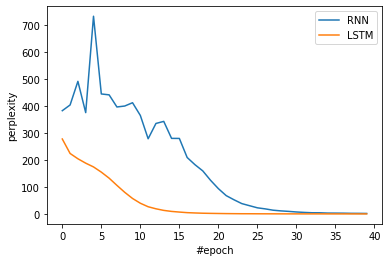

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(max_epoch), rnn_ppl_list)
plt.plot(range(max_epoch), lstm_ppl_list)
plt.legend(["RNN", "LSTM"])
plt.xlabel("#epoch")
plt.ylabel("perplexity")
plt.show()


## 提出可否

In [24]:
if rnn_ppl_list[-1] > 10:
    print("RNNの実装に間違いがあります。問1を見直してください。")
elif lstm_ppl_list[-1] > 5:
    print("LSTMの実装に間違いがあります。問2を見直してください。")
else:
    print("学習成功です。次のステップに進んでください。")

学習成功です。次のステップに進んでください。


## GRU
### GRUクラス

問3-1. <font color="Red">GRUクラスを完成させてください。</font>

GRUクラスの仕様はLSTMクラスとほとんど同じです。

各ゲートの計算と通常の順伝播の計算に使用するパラメータを行列にまとめ、一行で計算できるように実装しています。

r がリセットゲート、zが更新ゲートを表します。

In [25]:
class GRU:
    def __init__(self, Wx, Wh):
        self.params = [Wx, Wh]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh = self.params
        H, H3 = Wh.shape
        Wxz, Wxr, Wx = Wx[:, :H], Wx[:, H:2 * H], Wx[:, 2 * H:]
        Whz, Whr, Wh = Wh[:, :H], Wh[:, H:2 * H], Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat ######問3.1.1######

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next


    def backward(self, dh_next):
        Wx, Wh = self.params
        H, H3 = Wh.shape
        Wxz, Wxr, Wx = Wx[:, :H], Wx[:, H:2 * H], Wx[:, 2 * H:]
        Whz, Whr, Wh = Wh[:, :H], Wh[:, H:2 * H], Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        dWx = np.hstack((dWxz, dWxr, dWx))
        dWh = np.hstack((dWhz, dWhr, dWh))
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh


        return dx, dh_prev


### TimeGRUクラス

問3-2. <font color="Red">TimeGRUクラスを完成させてください。</font>

TimeGRUクラスの仕様はTimeLSTMクラスとほとんど同じです。


In [26]:
class TimeGRU:
    def __init__(self, input_size, output_size, stateful=False):
        D, H = input_size, output_size
        rn = np.random.randn
        np.random.seed(0)
        
        #Wx = (rn(######問3.2.1######) / np.sqrt(D)).astype('f') 
        Wx = (rn(D, 3 * H) / np.sqrt(D)).astype('f') ######問3.2.1###### 
        #Wh = (rn(######問3.2.2######) / np.sqrt(H)).astype('f') 
        Wh = (rn(H, 3 * H) / np.sqrt(H)).astype('f') ######問3.2.2###### 

        self.params = [Wx, Wh]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh)]
        self.layers = None
        self.h = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh = self.params
        N, T, D = xs.shape
        H, H3 = Wh.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(*self.params)
            # self.h = layer.forward(######問3.2.3######) 
            self.h = layer.forward(xs[:,t,:], self.h) ######問3.2.3###### 
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        grads = [0,0]
        dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            #dx, dh = layer.backward(######問3.2.4######) 
            dx, dh = layer.backward(dhs[:,t,:] + dh) ######問3.2.4###### 

            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
            
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


### GRUNetworkクラス



In [27]:
class GRUNetwork:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeGRU(D, H, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


## 学習、評価

ハイパーパラメータなどは先ほどのRNN・LSTMと全て共通で学習させます。

40エポックでperplexity が5以下となっていれば学習成功です。

In [28]:
model = GRUNetwork(vocab_size, wordvec_size, hidden_size)

time_idx = 0
total_loss = 0
loss_count = 0
gru_ppl_list = []

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        if max_grad is not None:
            clip_grads(model.grads, max_grad)

        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    gru_ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0


| epoch 1 | perplexity 288.44
| epoch 2 | perplexity 204.04
| epoch 3 | perplexity 170.58
| epoch 4 | perplexity 121.40
| epoch 5 | perplexity 77.48
| epoch 6 | perplexity 47.27
| epoch 7 | perplexity 31.21
| epoch 8 | perplexity 20.84
| epoch 9 | perplexity 13.75
| epoch 10 | perplexity 9.34
| epoch 11 | perplexity 6.24
| epoch 12 | perplexity 4.44
| epoch 13 | perplexity 3.38
| epoch 14 | perplexity 2.62
| epoch 15 | perplexity 2.13
| epoch 16 | perplexity 1.75
| epoch 17 | perplexity 1.58
| epoch 18 | perplexity 1.44
| epoch 19 | perplexity 1.35
| epoch 20 | perplexity 1.31
| epoch 21 | perplexity 1.25
| epoch 22 | perplexity 1.20
| epoch 23 | perplexity 1.19
| epoch 24 | perplexity 1.14
| epoch 25 | perplexity 1.13
| epoch 26 | perplexity 1.11
| epoch 27 | perplexity 1.11
| epoch 28 | perplexity 1.06
| epoch 29 | perplexity 1.06
| epoch 30 | perplexity 1.05
| epoch 31 | perplexity 1.04
| epoch 32 | perplexity 1.02
| epoch 33 | perplexity 1.02
| epoch 34 | perplexity 1.01
| epoch 35

GRUとLSTM、RNNの学習結果を比較し、GRUがLSTMと同様（若しくはそれ以上）の性能を持っていることを確認してください。

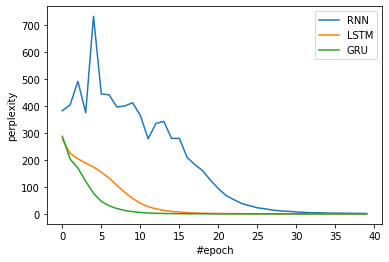

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(max_epoch), rnn_ppl_list)
plt.plot(range(max_epoch), lstm_ppl_list)
plt.plot(range(max_epoch), gru_ppl_list)
plt.legend(["RNN", "LSTM", "GRU"])
plt.xlabel("#epoch")
plt.ylabel("perplexity")
plt.show()


## 提出可否

In [30]:
if gru_ppl_list[-1] > 5:
    print("GRUの実装に間違いがあります。問3を見直してください。")
else:
    print("学習成功です。次のステップに進んでください。")

学習成功です。次のステップに進んでください。


## Classification
では実際にRNNやLSTMを用いて実践的な問題を解いていきましょう。

今回解いていくタスクは二値分類なので、まずは出力層の活性化と損失関数をつなげたSigmoidWithLossクラスを定義します。

In [31]:
class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t = t
        x = x.flatten()
        self.y = sigmoid(x)
        self.loss = -np.mean(np.log(self.y + 1e-7) * t + np.log(1 - self.y + 1e-7) * (1 - t))
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t)/batch_size
        dx = dx.reshape(-1,1)
        return dx

## データセットの用意

今回使用するデータは "movie review" と呼ばれる映画の評論記事の分類問題です。
評論記事に対して「1(positive)」「0(negative)」の二値がラベルとして付与されています。

In [41]:
from gensim.models import word2vec
import gensim.downloader as api
from sklearn.model_selection import train_test_split

In [42]:
def load_movie_reviews():
    from nltk.corpus import movie_reviews
    try:
        movie_reviews.categories()
    except:
        import nltk
        nltk.download('movie_reviews')
        from nltk.corpus import movie_reviews
    raw_data = []

    # NLTK's corpus is structured in an interesting way
    # first iterate through the two categories (pos and neg)
    for category in movie_reviews.categories():

        if category == 'pos':
            label = '1'
        elif category == 'neg':
            label = '0'

        # each of these categories is just fileids, so grab those
        for fileid in movie_reviews.fileids(category):
            # then each review is a NLTK class where each item in that class instance is a word
            review_words = list(movie_reviews.words(fileid))
            if len(review_words) >= 400:
                review_words = review_words[:400]
            else:
                review_words.extend([" " for i in range(400 - len(review_words))])
            review_dictionary = {
                'text': review_words,
                'label': label
            }

            raw_data.append(review_dictionary)

    return raw_data 

In [43]:
if os.path.exists("data.pkl"):
    f = open("data.pkl", "rb")
    data = pickle.load(f)
    f.close()
else:
    data = load_movie_reviews()
    f = open("data.pkl", "wb")
    pickle.dump(data,f)
    f.close()

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Masashi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


## Embedder の用意

先ほどの例ではEmbed層をネットワーク内に含めていましたが、Embed 層も含めて学習をすると時間がかかってしまうため、今回はあらかじめ用意された embedder を使用してネットワークに入れる前に単語列をベクトル化しておきます。

embedderモデルのダウンロードには時間がかかりますのでご注意ください。

In [44]:
if os.path.exists("embedder.model"):
    model = word2vec.Word2VecKeyedVectors.load_word2vec_format("embedder.model")
else:
    model = api.load("glove-twitter-25")
    model.save_word2vec_format("embedder.model")

In [45]:
def embed_one_word_via_model(word, model):
    try:
        return model[word]
    except:
        return np.zeros(model.vector_size)

In [46]:
embedding = []
labels = []
for d in data:
    embedding.append(np.array([embed_one_word_via_model(word,model) for word in d["text"]]))
    labels.append(int(d["label"]))
embedding = np.array(embedding)
labels = np.array(labels)

X_train, X_test, T_train, T_test = train_test_split(embedding, labels, random_state=0)

## ネットワーク の用意
問4-1. <font color="Red">以下の SimpleRNNClassifier, LSTMClassifier クラスを完成させてください。</font>

先ほどの問題では各時刻の入力に対して一つずつ出力が計算されましたが、今回のタスクにおいては、全時刻の入力データに対して一つの出力を計算します。

そのため、順伝播においてRNN層やLSTM層の出力に対して、時系列のうち最終出力のみを取り出し、Affine層に入力します。

In [0]:
class SimpleRNNClassifier:
    def __init__(self, wordvec_size, hidden_size):
        D, H = wordvec_size, hidden_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, 1) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(1).astype('f')

        # レイヤの生成
        self.affine_layer = Affine(affine_W, affine_b)
        self.loss_layer = SigmoidWithLoss()
        self.rnn_layer = TimeRNN(D, H, stateful=False)

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        self.params += self.rnn_layer.params
        self.grads += self.rnn_layer.grads
        self.params += self.affine_layer.params
        self.grads += self.affine_layer.grads

    def forward(self, xs, ts):
        xs = self.predict(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def predict(self, xs):
        xs = self.rnn_layer.forward(xs)[######問4.1.1######] 
        xs = self.affine_layer.forward(xs)
        return xs

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine_layer.backward(dout)
        dout = self.rnn_layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


In [0]:
class LSTMClassifier:
    def __init__(self, wordvec_size, hidden_size):
        D, H = wordvec_size, hidden_size
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        rnn_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, 1) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(1).astype('f')

        # レイヤの生成
        self.affine_layer = Affine(affine_W, affine_b)
        self.loss_layer = SigmoidWithLoss()
        self.rnn_layer = TimeLSTM(D, H, stateful=False)

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        self.params += self.rnn_layer.params
        self.grads += self.rnn_layer.grads
        self.params += self.affine_layer.params
        self.grads += self.affine_layer.grads

    def forward(self, xs, ts):
        xs = self.predict(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def predict(self, xs):
        xs = self.rnn_layer.forward(xs)[######問4.1.2######] 
        xs = self.affine_layer.forward(xs)
        return xs

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine_layer.backward(dout)
        dout = self.rnn_layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


## 学習の実行
今回のタスクにおいては、RNNではうまく学習が行われず損失があまり減少してくれません。

対してLSTMでは、環境によって結果に差は出ますが、RNNに比べると順調に損失が減少します。

学習の実行には少々時間がかかるため、注意してください。

In [0]:
lr = 0.01
n_epoch = 10
eval_interval = 5

In [0]:
rnn_model = SimpleRNNClassifier(25, 100)
lstm_model = LSTMClassifier(25, 100)
optimizer1 = Adam(lr)
optimizer2 = Adam(lr)
batch_size = 100
rnn_loss_list = []
lstm_loss_list = []

np.random.seed(0)
for epoch in range(n_epoch):
    total_rnn_loss = 0
    total_lstm_loss = 0
    perm = np.random.permutation(len(X_train))
    for i, idx in enumerate(range(0, len(X_train), batch_size)):
        X_batch = X_train[perm[idx:idx+batch_size]]
        T_batch = T_train[perm[idx:idx+batch_size]]
        
        rnn_loss = rnn_model.forward(X_batch, T_batch)
        rnn_model.backward()
        optimizer1.update(rnn_model.params, rnn_model.grads)
        total_rnn_loss += rnn_loss*len(X_batch)
        
        lstm_loss = lstm_model.forward(X_batch, T_batch)
        lstm_model.backward()
        optimizer2.update(lstm_model.params, lstm_model.grads)
        total_lstm_loss += lstm_loss*len(X_batch)
        if i % eval_interval == 0:
            print('| idx %d / %d | RNN loss %.2f | LSTM loss %.2f |'
                 %(idx, len(X_train), total_rnn_loss/(idx+batch_size), total_lstm_loss/(idx+batch_size)))
    average_rnn_loss = total_rnn_loss / len(X_train)
    rnn_loss_list.append(average_rnn_loss)
    average_lstm_loss = total_lstm_loss / len(X_train)
    lstm_loss_list.append(average_lstm_loss)
    rnn_pred = rnn_model.predict(X_test).flatten()
    lstm_pred = lstm_model.predict(X_test).flatten()
    rnn_accuracy = ((rnn_pred > 0) == T_test).mean() * 100
    lstm_accuracy = ((lstm_pred > 0) == T_test).mean() * 100
    print('| epoch %d | RNN loss %.2f | LSTM loss %.2f | RNN accuracy %.2f | LSTM accuracy %.2f'
          % (epoch+1, average_rnn_loss, average_lstm_loss, rnn_accuracy, lstm_accuracy))

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(n_epoch), rnn_loss_list)
plt.plot(range(n_epoch), lstm_loss_list)
plt.legend(["RNN", "LSTM"])
plt.xlabel("#epoch")
plt.ylabel("Cross Entropy Loss")
plt.show()

## bi-directional LSTM
問4-2. <font color="Red">以下の BidirectionalLSTMClassifier クラスを完成させてください。</font>

入力系列データに対して、順方向のデータを処理するforward LSTM層と逆方向のデータを処理するbackward LSTM層を用意します。

通常のLSTM層とパラメータ数が大きく変わらないように各LSTM層は hidden_size の半分の次元数を出力します。

forward LSTM と backward LSTM の出力を横につなげ、affine層に入力し分類タスクを解きます。

In [0]:
class BidirectionalLSTMClassifier:
    def __init__(self, wordvec_size, hidden_size):
        D, H = wordvec_size, hidden_size //2
        rn = np.random.randn
        np.random.seed(0)

        # 重みの初期化
        affine_W = (rn(H * 2, 1) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(1).astype('f')

        # レイヤの生成
        self.affine_layer = Affine(affine_W, affine_b)
        self.loss_layer = SigmoidWithLoss()
        self.forward_rnn_layer = TimeLSTM(D, H, stateful=False)
        self.backward_rnn_layer = TimeLSTM(D, H, stateful=False)

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        self.params += self.forward_rnn_layer.params
        self.grads += self.forward_rnn_layer.grads
        self.params += self.backward_rnn_layer.params
        self.grads += self.backward_rnn_layer.grads
        self.params += self.affine_layer.params
        self.grads += self.affine_layer.grads

    def forward(self, xs, ts):
        xs = self.predict(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def predict(self, xs):
        forward_xs = self.forward_rnn_layer.forward(xs)[######問4.2.1######] 
        backward_xs = self.backward_rnn_layer.forward(xs[######問4.2.2######])[######問4.2.3######] 
        xs = np.hstack((forward_xs, backward_xs))
        xs = self.affine_layer.forward(xs)
        return xs

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        dout = self.affine_layer.backward(dout)
        dout1, dout2 = np.hsplit(dout, 2)
        dout1 = self.forward_rnn_layer.backward(dout1)
        dout2 = self.backward_rnn_layer.backward(dout2)
        return (dout1, dout2)

    def reset_state(self):
        self.forward_rnn_layer.reset_state()
        self.backward_rnn_layer.reset_state()



## 学習の実行
Bidirectional LSTM がLSTMより良い性能を出していることを確認してください。

10エポックで損失が0.2を下回っていれば学習成功です。

In [0]:
lr = 0.01
n_epoch = 10
eval_interval = 5

In [0]:
bilstm_model = BidirectionalLSTMClassifier(25, 100)
optimizer = Adam(lr)
batch_size = 100
bilstm_loss_list = []
np.random.seed(0)
for epoch in range(n_epoch):
    total_bilstm_loss = 0
    perm = np.random.permutation(len(X_train))
    for i, idx in enumerate(range(0, len(X_train), batch_size)):
        X_batch = X_train[perm[idx:idx+batch_size]]
        T_batch = T_train[perm[idx:idx+batch_size]]
        
        bilstm_loss = bilstm_model.forward(X_batch, T_batch)
        bilstm_model.backward()
        optimizer.update(bilstm_model.params, bilstm_model.grads)
        total_bilstm_loss += bilstm_loss*len(X_batch)
        if i % eval_interval == 0:
            print('| idx %d / %d | BiLSTM loss %.2f |'
                 %(idx, len(X_train), total_bilstm_loss/(idx+batch_size)))

    average_bilstm_loss = total_bilstm_loss / len(X_train)
    bilstm_loss_list.append(average_bilstm_loss)
    bilstm_pred = bilstm_model.predict(X_test).flatten()
    bilstm_accuracy = ((bilstm_pred > 0) == T_test).mean() * 100
    print('| epoch %d | BiLSTM loss %.2f | BiLSTM accuracy %.2f'
          % (epoch+1, average_bilstm_loss, bilstm_accuracy))

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(n_epoch), rnn_loss_list)
plt.plot(range(n_epoch), lstm_loss_list)
plt.plot(range(n_epoch), bilstm_loss_list)
plt.legend(["RNN", "LSTM", "BiLSTM"])
plt.xlabel("#epoch")
plt.ylabel("Cross Entropy Loss")
plt.show()


## 提出可否

In [0]:
if average_bilstm_loss > 0.2:
    print("RNNの実装に間違いがあります。問4を見直してください。")
else:
    print("学習成功です。次のステップに進んでください。")

## Seq2Seq
## データセット用意

Seq2seq を用いてタスクを解いていきます。

今回用いるデータセットは、足し算の数式を並べたものになります。数式とその答を全て文字列として考え、足し算の式をLSTMによって一文字ずつ読み込み、その答えを一文字ずつ出力していきます。

In [0]:
id_to_char = {}
char_to_id = {}


def _update_vocab(txt):
    chars = list(txt)

    for i, char in enumerate(chars):
        if char not in char_to_id:
            tmp_id = len(char_to_id)
            char_to_id[char] = tmp_id
            id_to_char[tmp_id] = char

def load_sequence(file_name='addition.txt'):
    file_path = './' + file_name

    if not os.path.exists(file_path):
        print('No file: %s' % file_name)
        return None

    questions, answers = [], []

    for line in open(file_path, 'r'):
        idx = line.find('_')
        questions.append(line[:idx])
        answers.append(line[idx:-1])

    # create vocab dict
    for i in range(len(questions)):
        q, a = questions[i], answers[i]
        _update_vocab(q)
        _update_vocab(a)

    # create np array
    x = np.zeros((len(questions), len(questions[0])), dtype=np.int)
    t = np.zeros((len(questions), len(answers[0])), dtype=np.int)

    for i, sentence in enumerate(questions):
        x[i] = [char_to_id[c] for c in list(sentence)]
    for i, sentence in enumerate(answers):
        t[i] = [char_to_id[c] for c in list(sentence)]

    # shuffle
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    x = x[indices]
    t = t[indices]

    # 10% for validation set
    split_at = len(x) - len(x) // 10
    (x_train, x_test) = x[:split_at], x[split_at:]
    (t_train, t_test) = t[:split_at], t[split_at:]

    return (x_train, t_train), (x_test, t_test)


def get_vocab():
    return char_to_id, id_to_char


In [0]:
(x_train, t_train), (x_test, t_test) = load_sequence('addition.txt')
char_to_id, id_to_char = get_vocab()

## ネットワーク定義
問5. <font color="Red">以下の Seq2seq クラスを完成させてください。</font>

  - Encoderクラスは、各時刻での入力を順伝播させた後、最後の時刻に対応する出力をDecoder クラスに渡します。
  - Decoderクラスの順伝播では、まずEncoderクラスの出力を内部状態としてセットし、入力系列データを順伝播させていきます。

In [0]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
 
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(D, H, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[######問4.1######]

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(D, H, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(######問4.2######)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

class Seq2seq():
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs) 
        score = self.decoder.forward(decoder_xs, h) 
        loss = self.softmax.forward(score, decoder_ts) 
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout


In [0]:
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 8
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hideen_size)
optimizer = Adam()

data_size = len(x_train)
max_iters = data_size // batch_size
loss_list = []
eval_interval = 50
current_epoch = 0

### 学習、評価

In [0]:
for epoch in range(max_epoch):
    # シャッフル
    idx = np.random.permutation(np.arange(data_size))
    x = x_train[idx]
    t = t_train[idx]
    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]
        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
#         params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
        if max_grad is not None:
            clip_grads(model.grads, max_grad)
        optimizer.update(model.params,model.grads)
        total_loss += loss
        loss_count += 1
        # 評価
        if (eval_interval is not None) and (iters % eval_interval) == 0:
            avg_loss = total_loss / loss_count
            print('| epoch %d |  iter %d / %d | loss %.2f'
                  % (current_epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(float(avg_loss))
            total_loss, loss_count = 0, 0
    current_epoch += 1

In [0]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss_list)), loss_list)
plt.xlabel("#iter")
plt.ylabel("Cross Entropy Loss")
plt.show()


## 提出可否

In [0]:
if loss_list[-1] > 1.1:
    print("Seq2seqの実装に間違いがあります。問4を見直してください。")
else:
    print("学習成功です。提出してください")